# Compare different classification tecniques

![image](https://miro.medium.com/max/775/1*Qn4eJPhkvrEQ62CtmydLZw.png)

- Typical Classification problem with 2, 3, 4 (or more) outputs.
- Most of the time the output consists of binary (male/female, spam/nospam,yes/no) 
- Sometime, there are more than binary output: dog/cat/mouse, red/green/yellow.

In this category, we gonna use an existing dataset from [sklearn](https://scikit-learn.org/stable/datasets.html):
- [Breast Cancer Wisconsine](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-wisconsin-diagnostic-dataset) data for Binary output


In [2]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = data.data
y = data.target
print("There are", X.shape[1], " Predictors: ", data.feature_names)
print("The output has 2 values: ", data.target_names)
print("Total size of data is ", X.shape[0], " rows")


There are 30  Predictors:  ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
The output has 2 values:  ['malignant' 'benign']
Total size of data is  569  rows


We can see that there are 30 input data representing the shape and size of 569 tumours.
Base on that, the tumour can be considered _malignant_ or _benign_ (0 or 1 as in number)


### Partitioning Data to train/test:

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=123)


### Train model using Logistic Regression
For simplicity, we use all predictors for the regression:


In [12]:
from sklearn.linear_model import LogisticRegression
model_LogReg = LogisticRegression(solver='newton-cg').fit(X_train, y_train)
y_pred_LogReg = model_LogReg.predict(X_test)

### Train model using Principal Component Regressions and KNN with 4 PCs

In [6]:
# First scale the input data:
from sklearn.preprocessing import StandardScaler
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

In [8]:
# Apply PCA:

from sklearn.decomposition import PCA
pca = PCA()
PCs = pca.fit_transform(X_train_scaled)
PCs.shape

pca.explained_variance_ratio_
print("The first 4 components represent %1.3f" % pca.explained_variance_ratio_[0:4].sum(), " total variance")

The first 4 components represent 0.791  total variance


In [20]:
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
pca = PCA(n_components=4) #We choose number of principal components to be 4

X_train_pca = pd.DataFrame(pca.fit_transform(X_train_scaled))
X_test_pca = pd.DataFrame(pca.transform(X_test_scaled))
X_train_pca.columns = ['PC1','PC2','PC3','PC4']
X_test_pca.columns  = ['PC1','PC2','PC3','PC4']

# Use KNN to train model
model_PCA_KNN = KNeighborsClassifier().fit(X_train_pca, y_train)
y_pred_PCA_KNN = model_PCA_KNN.predict(X_test_pca)


### Train model using ANN MLP

In [14]:
# First scale the input data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# Using MLP to predict 
from sklearn.neural_network import MLPClassifier
model_MLP = MLPClassifier(hidden_layer_sizes = (50,20),solver='lbfgs',activation='relu',random_state=123).fit(X_train_scaled, y_train)
y_pred_MLP = model_MLP.predict(X_test_scaled)

### Evaluate model output:


In [16]:
from sklearn import metrics
print("The accuracy score from Logistic Regression is %1.3f" % metrics.accuracy_score(y_test,y_pred_LogReg))
print("The accuracy score from PCA4 and KNN is %1.3f" % metrics.accuracy_score(y_test,y_pred_KNN))
print("The accuracy score from MLP is %1.3f" % metrics.accuracy_score(y_test,y_pred_MLP))



The accuracy score from Logistic Regression is 0.965
The accuracy score from PCA4 and KNN is 0.974
The accuracy score from MLP is 0.971


### Compute AUC-ROC and plot curve


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.990
PCA KNN: ROC AUC=0.992
MLP: ROC AUC=0.982


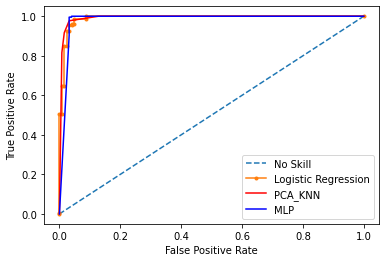

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

probs_LogReg = model_LogReg.predict_proba(X_test)
probs_PCA_KNN = model_PCA_KNN.predict_proba(X_test_pca)
probs_MLP = model_MLP.predict_proba(X_test_scaled)

# generate a no skill prediction (majority class)
probs_ns = np.zeros(len(y_test))

# calculate AUC scores
auc_ns = roc_auc_score(y_test, probs_ns)
auc_LogReg = roc_auc_score(y_test, probs_LogReg[:,1])
auc_PCA_KNN = roc_auc_score(y_test, probs_PCA_KNN[:,1])
auc_MLP = roc_auc_score(y_test, probs_MLP[:,1])

# summarize scores
print('No Skill: ROC AUC=%.3f' % (auc_ns))
print('Logistic: ROC AUC=%.3f' % (auc_LogReg))
print('PCA KNN: ROC AUC=%.3f' % (auc_PCA_KNN))
print('MLP: ROC AUC=%.3f' % (auc_MLP))

# calculate roc curves
fpr_ns, tpr_ns, _ = roc_curve(y_test, probs_ns)
fpr_LogReg, tpr_LogReg, _ = roc_curve(y_test, probs_LogReg[:,1])
fpr_PCA_KNN, tpr_PCA_KNN, _ = roc_curve(y_test, probs_PCA_KNN[:,1])
fpr_MLP, tpr_MLP, _ = roc_curve(y_test, probs_MLP[:,1])

# plot the roc curve for the model
plt.plot(fpr_ns, tpr_ns, linestyle='--', label='No Skill')
plt.plot(fpr_LogReg, tpr_LogReg, marker='.', label='Logistic Regression')
plt.plot(fpr_PCA_KNN, tpr_PCA_KNN, color="red", label='PCA_KNN')
plt.plot(fpr_MLP, tpr_MLP, color="blue", label='MLP')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
